# ECE 657 ASSIGNMENT 2: Problem 3
## NLP (Classification of IMDB Movie Reviews)

Jubilee Imhanzenobe: 20809735  
Olohireme Ajayi: 20869827  
Harnoor Singh: 20870613

In [1]:
# import required packages
import pandas as pd
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
from sklearn.model_selection import train_test_split
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, LSTM
from gensim.models import Word2Vec, KeyedVectors
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import numpy as np
from utils import *

In [2]:
# Importing the training and testing datasets
# extract data if it hasnt already been extracted and saved as csv
if not 'train_data_NLP.csv' in os.listdir("data"):
    X_train, y_train = load_data()
    train_data = pd.DataFrame([X_train, y_train]).transpose()
    train_data.columns = ["Review", "Rating"]

    X_test, y_test = load_data(False)
    test_data = pd.DataFrame([X_test, y_test]).transpose()
    test_data.columns = ["Review", "Rating"]

    # saving the datasets as csv files for ease of loading
    train_data.to_csv("data/train_data_NLP.csv", index = False)
    test_data.to_csv("data/test_data_NLP.csv", index = False)

In [3]:
# loading the dataset from saved file
train_data = pd.read_csv("data/train_data_NLP.csv")

### Data Preprocessing

We first preprocess the reviews to make them ready for our NLP embedding techniques.

During preprocessing, all special characters were removed and each review was tokenized i.e separated into a list containing the individual words.

Next, the words were stemmed using potterstemmer to reduce every word to its root word. The Porter stemming is a process for removing the commoner morphological and inflexional endings from words in English. It is mainly used as part of the term normalisation process usually done when setting up Information Retrieval systems.

Finally, the tokenized words were joined back together to get a preprocessed review.

In [4]:
""" Data Preprocessing """
# preprocessing the reviews in the training data
train_data['Token'] = train_data['Review'].apply(preprocess_sentence)

In [5]:
# Before preprocessing
train_data['Review'][0]

'Bromwell High is a cartoon comedy. It ran at the same time as some other programs about school life, such as "Teachers". My 35 years in the teaching profession lead me to believe that Bromwell High\'s satire is much closer to reality than is "Teachers". The scramble to survive financially, the insightful students who can see right through their pathetic teachers\' pomp, the pettiness of the whole situation, all remind me of the schools I knew and their students. When I saw the episode in which a student repeatedly tried to burn down the school, I immediately recalled ......... at .......... High. A classic line: INSPECTOR: I\'m here to sack one of your teachers. STUDENT: Welcome to Bromwell High. I expect that many adults of my age think that Bromwell High is far fetched. What a pity that it isn\'t!'

In [6]:
# After preprocessing
train_data['Token'][0]

'bromwel high cartoon comedi ran time program school life teacher year teach profess lead believ bromwel high satir much closer realiti teacher scrambl surviv financi insight student see right pathet teacher pomp petti whole situat remind school knew student saw episod student repeatedli tri burn school immedi recal high classic line inspector im sack one teacher student welcom bromwel high expect mani adult age think bromwel high far fetch piti isnt'

### Model 1 (Using Count Vectorizer)

Count Vectorizer is an embedding method for textual data it is also called Term Frequency Embedding. It transforms a given text into a vector on the basis of the frequency (count) of each word that occurs in the entire text. It creates a sparse matrix with each unique word being represented by a column in the matrix and the value of each element is the frequency of the particular word in the text sample.  

A 5000 feature vectorization was chosen so that is large enough to properly represent the large sized corpus yet small enough for good running efficiency.

A 5 layer ANN (1 input, 3 hidden, 1 output) was used in the classification of the embedded movie reviews. Due to the large input dimensions, dropout layers were added between hidden layers to prevent overfitting of the network to the training set. The network was also trained for 30 epochs to observe the learning pattern of the network and a batch size of 128 was used.

In [7]:
epochs = 30

In [8]:
# creating the word embedding using count vectorizer
X, CV = word_vectorizer(train_data.Token, "CountVectorizer", 5000)
y = train_data.Rating

# splittint the data into training and validatuion set
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.10, random_state=0)

In [9]:
""" Building the ANN model """
model = Sequential()

# Input - Layer
model.add(Dense(128, activation = "relu", input_shape=(X_train.shape[1], )))

# Hidden - Layers
model.add(Dropout(0.3, seed=None))
model.add(Dense(32, activation = "relu"))
model.add(Dropout(0.2, seed=None))
model.add(Dense(16, activation = "relu"))

# Output- Layer
model.add(Dense(1, activation = "sigmoid"))
model.summary()

#Compiling the ANN
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               640128    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                4128      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 644,801
Trainable params: 644,801
Non-trainable params: 0
__________________________________________________

In [10]:
%%capture
history = model.fit(X_train,y_train,
                    epochs = epochs,
                    validation_data = (X_val, y_val),
                    verbose = 1, # print result every epoch
                    batch_size = 128)

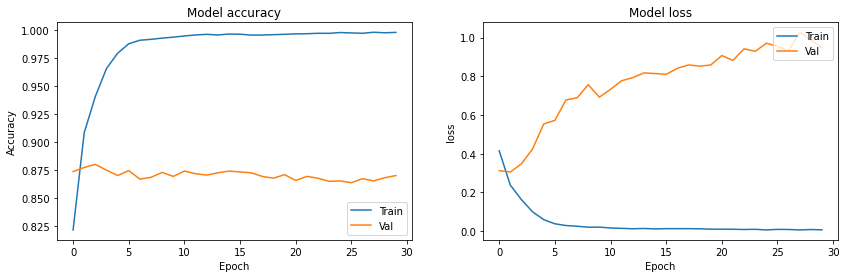

In [11]:
accuracy_loss_plot(history)

In [12]:
print_final_result(history)


 ******************** Training set Evaluation ********************
Final Train accuracy:  0.9981
Final Train loss:  0.0064

 ******************** Validation set Evaluation ********************
Final Val accuracy:  0.87
Final Val loss:  0.9468


### Model 2 (Using TF-IDF Vectorizer)

Term Frequency-Inverse Document Frequency Vectorizer (TF-IDF) is similar to Count Vectorizer in that it embeds words based on the frequency of a word in the corpus but it also provides a numerical representation of the importance of the words. The term frequency (TF) refers to the count of a word in a sentence and the document frequency (DF) refers to the number of documents in the corpus that contain the particular word.

A 5000 feature vectorization was chosen so that is large enough to properly represent the large sized corpus yet small enough for good running efficiency.

A 5 layer ANN (1 input, 3 hidden, 1 output) was used in the classification of the embedded movie reviews. Due to the large input dimensions, dropout layers were added between hidden layers to prevent overfitting of the network to the training set. The network was also trained for 30 epochs to observe the learning pattern of the network and a batch size of 128 was used.

In [13]:
# creating the word embedding using count vectorizer
X2, TFIDF = word_vectorizer(train_data.Token, "TFIDF", 5000)

# splittint the data into training and validatuion set
X_train2, X_val2, y_train2, y_val2 = train_test_split(X2, y, test_size=0.10, random_state=0)

In [14]:
""" Building the ANN model """
model2 = Sequential()

# Input - Layer
model2.add(Dense(128, activation = "relu", input_shape=(X_train2.shape[1], )))

# Hidden - Layers
model2.add(Dropout(0.3, seed=None))
model2.add(Dense(32, activation = "relu"))
model2.add(Dropout(0.2, seed=None))
model2.add(Dense(16, activation = "relu"))

# Output- Layer
model2.add(Dense(1, activation = "sigmoid"))
model2.summary()

#Compiling the ANN
model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 128)               640128    
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 32)                4128      
_________________________________________________________________
dropout_3 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 17        
Total params: 644,801
Trainable params: 644,801
Non-trainable params: 0
________________________________________________

In [15]:
%%capture
history2 = model2.fit(X_train2,y_train2,
                    epochs = epochs,
                    validation_data = (X_val2, y_val2),
                    verbose = 1, # print result every epoch
                    batch_size = 128)

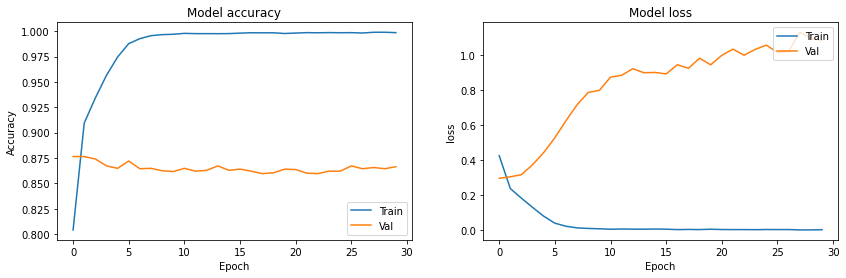

In [16]:
accuracy_loss_plot(history2)

In [17]:
print_final_result(history2)


 ******************** Training set Evaluation ********************
Final Train accuracy:  0.9986
Final Train loss:  0.004

 ******************** Validation set Evaluation ********************
Final Val accuracy:  0.8664
Final Val loss:  1.0852


### Preprocessing for Word2Vec and Doc2Vec

For Word2Vec and Doc2Vec, the the reviews were preprocessed slightly differently. Like before, all special characters were removed and each review was tokenized i.e separated into a list containing then individual words. Finally, the words were Lemmatized to reduce every word to its root word. Lemmatization like Porter Stemmimg aims to reduce words to their root words but lemmatization considers the vocabulary and morphological analysis of words while aiming to remove inflectional endings only and to return the base or dictionary form of a word, which is known as the lemma . 
e.g if the word **saw** is stemmed, the result may be **s** whereas if it is lemmatized the result will be **see** or **saw** depending on whether the use of the token was as a verb or a noun.

The lemmatized tokens of the reviews were then used to get the Word2Vec feature embedding.

### Model 3 (Using Word2Vec)

Word2Vec unlike the previously used vectorizers actually embeds the meaning of a word by inferring it from its context. It uses a linguistic technique which uses the context in which a word appears to infer its meaning. Word2Vec only gets the embeddings of words and is usually very good for finding relationships between words but it doesn't embed sentences. 

Here, we got the sentence embeddings by averaging the embedding of every word in the sentence or review.

In [18]:
sentences = train_data["Review"].apply(w2v_preprocess)
w2v_model = Word2Vec(sentences=sentences, 
                     vector_size=100, 
                     window=5, 
                     min_count=5, 
                     workers=8)

In [19]:
w2v_model.wv.most_similar('review', topn=10)

[('comment', 0.9242464900016785),
 ('imdb', 0.8326272368431091),
 ('reviewers', 0.760803759098053),
 ('reviewer', 0.7367420792579651),
 ('summary', 0.7364093661308289),
 ('user', 0.7301311492919922),
 ('post', 0.7195536494255066),
 ('negative', 0.7160252332687378),
 ('website', 0.7016050219535828),
 ('critics', 0.7012093663215637)]

The cell above shows the ability of Word2Vec to find similarity between words. It shows a high similarity between **review**, **comments**, **reviewer**, **summary**, **post**, **opinion** which shows some level of semantical correctness in English grammar.

In [20]:
df_train = get_sentence_embedding(sentences, w2v_model)
X3 = df_train.iloc[:].values

In [21]:
# splitting the data into training and validatuion set
X_train3, X_val3, y_train3, y_val3 = train_test_split(X3, y, test_size=0.10, random_state=0)

In [22]:
""" Building the ANN model """
model3 = Sequential()

# Input - Layer
model3.add(Dense(128, activation = "relu", input_shape=(X_train3.shape[1], )))

# Hidden - Layers
model3.add(Dropout(0.3, seed=None))
model3.add(Dense(32, activation = "relu"))
model3.add(Dropout(0.2, seed=None))
model3.add(Dense(16, activation = "relu"))

# Output- Layer
model3.add(Dense(1, activation = "sigmoid"))
model3.summary()

#Compiling the ANN
model3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 128)               12928     
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 32)                4128      
_________________________________________________________________
dropout_5 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 17        
Total params: 17,601
Trainable params: 17,601
Non-trainable params: 0
__________________________________________________

In [23]:
%%capture
history3 = model3.fit(X_train3,y_train3,
                    epochs=epochs,
                    validation_data=(X_val3, y_val3),
                    verbose=1, # print result every epoch
                    batch_size=128)

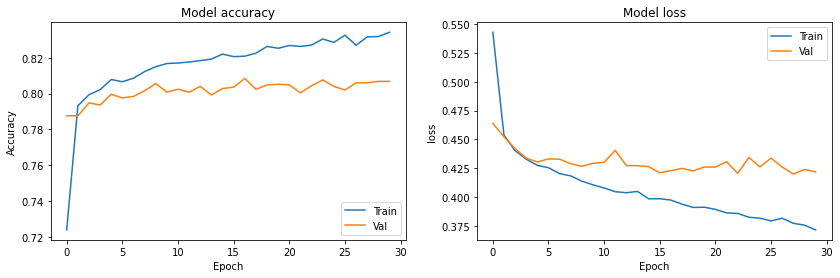

In [24]:
accuracy_loss_plot(history3)

In [25]:
print_final_result(history3)


 ******************** Training set Evaluation ********************
Final Train accuracy:  0.8342
Final Train loss:  0.3716

 ******************** Validation set Evaluation ********************
Final Val accuracy:  0.8068
Final Val loss:  0.4219


### Model 4 (Using Doc2Vec)

Unlike Word2Vec that trains on a single word, Doc2Vec trains on texts of variable length and with Doc2Vec, relationships between sentences or documents can be measured. Doc2Vec is a generalized extension of Word2Vec that is applied to a document as a whole instead of individual words. This model was developed by Le and Mikolov. It aims to create a numerical representation of a document rather than a word (Le & Mikolov, 2014). Doc2Vec operates on the logic that the meaning of a word also depends on its context and also the document that it occurs in. The vectors generated by Doc2Vec can be used for finding similarities between documents.  
The documents have to be tagged in the Doc2Vec training. The tagging can be done according to authors or topics or using any other criteria. In this model, the reviews were tagged serially. This method of tagging was chosen because the aim of the embeddings is to perform classification and we want the model to be robust and have low generalization error.

In [26]:
""" Using Doc2Vec """
tagged_data = [TaggedDocument(d, [i]) for i, d in enumerate(sentences)]

d2v_model = Doc2Vec(tagged_data, vector_size = 100, window = 5, min_count = 5, epochs = 20, workers=8)
embed = sentences.apply(d2v_model.infer_vector)

X4 = np.stack( embed, axis=0)

In [27]:
# splitting the data into training and validatuion set
X_train4, X_val4, y_train4, y_val4 = train_test_split(X4, y, test_size=0.10, random_state=0)

In [28]:
model4 = Sequential()

# Input - Layer
model4.add(Dense(128, activation = "relu", input_shape=(X_train4.shape[1], )))

# Hidden - Layers
model4.add(Dropout(0.3, seed=None))
model4.add(Dense(32, activation = "relu"))
model4.add(Dropout(0.2, seed=None))
model4.add(Dense(16, activation = "relu"))

# Output- Layer
model4.add(Dense(1, activation = "sigmoid"))
model4.summary()

#Compiling the ANN
model4.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 128)               12928     
_________________________________________________________________
dropout_6 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 32)                4128      
_________________________________________________________________
dropout_7 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 17        
Total params: 17,601
Trainable params: 17,601
Non-trainable params: 0
__________________________________________________

In [29]:
%%capture
history4 = model4.fit(X_train4,y_train4,
                    epochs=epochs,
                    validation_data=(X_val4, y_val4),
                    verbose=1, # print result every epoch
                    batch_size=128)

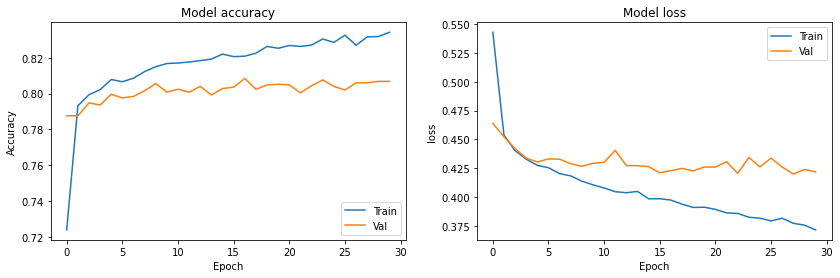

In [30]:
accuracy_loss_plot(history3)

In [31]:
print_final_result(history4)


 ******************** Training set Evaluation ********************
Final Train accuracy:  0.8972
Final Train loss:  0.2443

 ******************** Validation set Evaluation ********************
Final Val accuracy:  0.8272
Final Val loss:  0.4361


### Comparing the performance of the models

In [32]:
history_list = [history, history2, history3, history4]
labels = ["CV", "TFIDF", "Word2Vec", "Doc2Vec"]

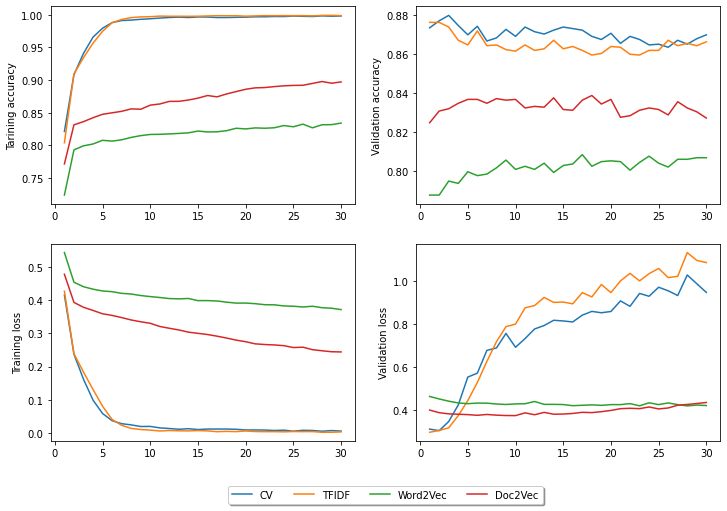

In [33]:
result = compare_models(history_list, labels, epochs)

From the plots, it can be seen that Count Vectorizer and TFIDF performed better than Word2Vec and Doc2vec in terms of training accuracy and validation accuracy. Although Count Vectorizer and TFIDF had lower training losses compared to Word2Vec and Doc2Vec, both of them had higher validation losses that Word2Vec and Doc2Vec. The contradiction in validation loss is actually due to the difference in dimensionality between CV/TFIDF (5000) and Word2Vec/Doc2Vec (100).

Also, as the number of epoch increased beyond 10, the training accuracy, training loss and validation accuracy for Count Vectorizer and TFID remained considerably constant but the validation loss for both embedding methods seemed to increase slightly.

Also, Word2Vec and Doc2Vec had lower generalization error compared to CV and TFIDF.

In [34]:
result

,Train Accuracy,Train Loss,Val Accuracy,Val Loss
CV,99.81,0.0064,87.00,0.9468
TFIDF,99.86,0.0040,86.64,1.0852
Word2Vec,83.42,0.3716,80.68,0.4219
Doc2Vec,89.72,0.2443,82.72,0.4361


The table above shows the final evaluation of the different embedding methods used after 30 epochs. From the results, CV and TFIDF have comparatively similar performances on the training and validation set but CV seemed to perform slightly better on the validation set and as such will be used for evaluating the test set. On the other hand, Doc2Vec preformed better than Word2Vec on the training and validation sets> This in indicative of their design as Word2Vec embeds words individually and is better for finding similarity and relationships between words unlike Doc2Vec which can embed entire documents and find similarity and relationships between documents. 

### Evaluating models on the test set

In [35]:
# Loading the test set data
test_data = pd.read_csv("data/test_data_NLP.csv")

#### Model 1 (Count Vectorizer)

In [36]:
# preprocessing the reviews in the training data
test_data['Token'] = test_data['Review'].apply(preprocess_sentence)

# Vectorizing using Bag of Words Model
X_test = CV.transform(test_data.Token).toarray()
y_test = test_data.Rating

# predicting the test set results
y_pred = (model.predict(X_test) >= 0.5).astype("int32")

accuracy = accuracy_score(y_pred, y_test)
F_score = f1_score(y_test, y_pred, average = "binary")
CM = confusion_matrix(y_pred, y_test)

print("Test accuracy: ", round(accuracy * 100, 2))
print("Test F_score: ", round(F_score, 4))
print("Test confusion matrix: \n", CM)

Test accuracy:  85.59
Test F_score:  0.8534
Test confusion matrix: 
 [[10914  2017]
 [ 1586 10483]]


#### Model 2 (TFIDF)

In [37]:
# Vectorizing using Bag of Words Model
X_test = TFIDF.transform(test_data.Token).toarray()

# predicting the test set results
y_pred = (model2.predict(X_test) > 0.5).astype("int32")

accuracy2 = accuracy_score(y_pred, y_test)
F_score2 = f1_score(y_test, y_pred, average = "binary")
CM2 = confusion_matrix(y_pred, y_test)

print("Test accuracy: ", round(accuracy2 * 100, 2))
print("Test F_score: ", round(F_score2, 4))
print("Test confusion matrix: \n", CM2)

Test accuracy:  84.72
Test F_score:  0.846
Test confusion matrix: 
 [[10682  2003]
 [ 1818 10497]]


#### Model 3 (Word2Vec)

In [38]:
# preprocess the reviews
test_sentences = test_data["Review"].apply(w2v_preprocess)

# get Word2Vec embeddings of test data
df_test = get_sentence_embedding(sentences, w2v_model)
X_test = df_test.iloc[:].values

# predicting the test set results
y_pred = (model3.predict(X_test) > 0.5).astype("int32")

accuracy3 = accuracy_score(y_pred, y_test)
F_score3 = f1_score(y_test, y_pred, average = "binary")
CM3 = confusion_matrix(y_pred, y_test)

print("Test accuracy: ", round(accuracy * 100, 2))
print("Test F_score: ", round(F_score, 4))
print("Test confusion matrix: \n", CM)

Test accuracy:  85.59
Test F_score:  0.8534
Test confusion matrix: 
 [[10914  2017]
 [ 1586 10483]]


#### Model 4 (Doc2Vec)

In [39]:
# get Doc2Vec embeddings of test data
test_embed = test_sentences.apply(d2v_model.infer_vector)
X_test = np.stack(test_embed, axis=0)

# predicting the test set results
y_pred = (model4.predict(X_test) > 0.5).astype("int32")

accuracy4 = accuracy_score(y_pred, y_test)
F_score4 = f1_score(y_test, y_pred, average = "binary")
CM4 = confusion_matrix(y_pred, y_test)

print("Test accuracy: ", round(accuracy * 100, 2))
print("Test F_score: ", round(F_score, 4))
print("Test confusion matrix: \n", CM)

Test accuracy:  85.59
Test F_score:  0.8534
Test confusion matrix: 
 [[10914  2017]
 [ 1586 10483]]


On the test set, Word2Vec, Doc2Vec and CV all had the same accuracy **85.59**. TFIDF on the other hand had an accuracy of **84.72**. This butresses the previous point about the generalization error of CV and TFIDF being greater than that of Word2Vec and Doc2Vev.